In [1]:
import scipy.io
import numpy as np
import scipy
from numpy import linalg as LA
from scipy.spatial import procrustes
import matplotlib.pyplot as plt
from scipy.spatial import procrustes
from math import atan
import math
from scipy.linalg import norm

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def dtw(s, t):
    n=s.shape[1]
    m=t.shape[1]
    #n, m = len(s), len(t)
    dtw_matrix = np.zeros((n+1, m+1))
    for i in range(n+1):
        for j in range(m+1):
            dtw_matrix[i, j] = np.inf
    dtw_matrix[0, 0] = 0
    
    for i in range(1, n+1):
        for j in range(1, m+1):
            #cost = abs(s[i-1] - t[j-1])
            cost = DistanceFrames(s[:,i-1,:],t[:,j-1,:])
            # take last min from a square box
            last_min = np.min([dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]])
            dtw_matrix[i, j] = cost + last_min
    return dtw_matrix

In [4]:
def procrustes(X, Y, scaling=True, reflection='best'):
    """
    A port of MATLAB's `procrustes` function to Numpy.

    Procrustes analysis determines a linear transformation (translation,
    reflection, orthogonal rotation and scaling) of the points in Y to best
    conform them to the points in matrix X, using the sum of squared errors
    as the goodness of fit criterion.

        d, Z, [tform] = procrustes(X, Y)

    Inputs:
    ------------
    X, Y    
        matrices of target and input coordinates. they must have equal
        numbers of  points (rows), but Y may have fewer dimensions
        (columns) than X.

    scaling 
        if False, the scaling component of the transformation is forced
        to 1

    reflection
        if 'best' (default), the transformation solution may or may not
        include a reflection component, depending on which fits the data
        best. setting reflection to True or False forces a solution with
        reflection or no reflection respectively.

    Outputs
    ------------
    d       
        the residual sum of squared errors, normalized according to a
        measure of the scale of X, ((X - X.mean(0))**2).sum()

    Z
        the matrix of transformed Y-values

    tform   
        a dict specifying the rotation, translation and scaling that
        maps X --> Y

    """

    n,m = X.shape
    ny,my = Y.shape

    muX = X.mean(0)
    muY = Y.mean(0)

    X0 = X - muX
    Y0 = Y - muY

    ssX = (X0**2.).sum()
    ssY = (Y0**2.).sum()

    # centred Frobenius norm
    normX = np.sqrt(ssX)
    normY = np.sqrt(ssY)

    # scale to equal (unit) norm
    X0 /= normX
    Y0 /= normY

    if my < m:
        Y0 = np.concatenate((Y0, np.zeros(n, m-my)),0)

    # optimum rotation matrix of Y
    A = np.dot(X0.T, Y0)
    U,s,Vt = np.linalg.svd(A,full_matrices=False)
    V = Vt.T
    T = np.dot(V, U.T)

    if reflection is not 'best':

        # does the current solution use a reflection?
        have_reflection = np.linalg.det(T) < 0

        # if that's not what was specified, force another reflection
        if reflection != have_reflection:
            V[:,-1] *= -1
            s[-1] *= -1
            T = np.dot(V, U.T)

    traceTA = s.sum()

    if scaling:

        # optimum scaling of Y
        b = traceTA * normX / normY

        # standarised distance between X and b*Y*T + c
        d = 1 - traceTA**2

        # transformed coords
        Z = normX*traceTA*np.dot(Y0, T) + muX

    else:
        b = 1
        d = 1 + ssY/ssX - 2 * traceTA * normY / normX
        Z = normY*np.dot(Y0, T) + muX

    # transformation matrix
    if my < m:
        T = T[:my,:]
    c = muX - b*np.dot(muY, T)

    #transformation values 
    tform = {'rotation':T, 'scale':b, 'translation':c}

    return d, Z, tform

<>:73: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:73: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-4-2c09cca0ca3f>:73: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if reflection is not 'best':


In [5]:
matrice = scipy.io.loadmat('sequences_ckp.mat')
TabSequences = matrice['sequences'][0]

labels = scipy.io.loadmat('labels_ckp.mat')
TabLabels = labels['labels'][0]

sujetID = scipy.io.loadmat('subject_labels_ckp.mat')
TabSubjects = sujetID['subject_labels']

In [6]:
print(type(matrice),type(TabSequences),type(labels),type(TabLabels),type(sujetID),type(TabSubjects))

<class 'dict'> <class 'numpy.ndarray'> <class 'dict'> <class 'numpy.ndarray'> <class 'dict'> <class 'numpy.ndarray'>


In [7]:
print(matrice)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Fri Sep  7 15:40:41 2018', '__version__': '1.0', '__globals__': [], 'sequences': array([[array([[[249.981155, 174.693588],
                [249.331375, 175.958359],
                [250.818314, 174.199127],
                ...,
                [251.822891, 175.453918],
                [250.476578, 175.750748],
                [252.250519, 174.429718]],

               [[269.659912, 159.130112],
                [269.934509, 159.785522],
                [270.891418, 158.745117],
                ...,
                [272.337402, 162.449112],
                [271.244446, 162.815247],
                [272.761108, 162.671448]],

               [[294.172333, 155.070694],
                [294.930878, 155.126862],
                [295.543671, 155.241318],
                ...,
                [296.490417, 159.753677],
                [295.880951, 160.681442],
                [296.144409, 160.756271]],

               ...,

    

In [8]:
TabSequences.shape

(327,)

In [9]:
print(TabSequences[0].shape)
# La première dimension correspond aux points qui décrivent le visage 
# La deuxième correspond aux nombres de visages dans la séquence
# La troisième correspond aux coordonnées des points

(49, 11, 2)


In [10]:
print(TabSequences[0][:,0,0])

[249.981155 269.659912 294.172333 319.14502  342.848083 392.882446
 415.242645 439.948181 465.286377 487.588409 371.771942 373.84671
 375.50946  376.835815 349.556305 362.569153 377.704956 391.075378
 401.865051 283.156006 298.487793 317.403625 332.388214 315.90918
 299.204681 411.513702 424.298187 443.424103 460.41095  443.972198
 427.25943  328.618622 342.64975  359.276245 377.951538 396.298462
 414.04657  428.122955 414.845673 397.848785 379.547577 361.567841
 343.616028 357.61142  378.528168 398.41626  399.074097 378.687012
 357.401703]


In [11]:
print(TabSequences[0][:,0,1])

[174.693588 159.130112 155.070694 159.428879 168.303513 166.339966
 155.579987 148.702393 150.348892 162.862228 193.668396 220.380798
 248.01268  275.519348 287.553436 293.526428 295.421936 291.855286
 285.219177 201.644989 190.618118 190.410553 202.650589 208.225403
 208.312759 199.326065 185.529877 184.045258 194.079575 202.233078
 203.317444 338.589386 325.573242 316.181305 318.558167 314.832855
 321.635468 334.172302 346.990784 355.785767 357.648926 357.559753
 350.591705 333.187195 333.790253 330.594147 330.437347 334.313507
 333.334656]


In [12]:
print(labels)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Fri Jul 20 15:22:31 2018', '__version__': '1.0', '__globals__': [], 'labels': array([[3, 7, 1, 5, 7, 6, 4, 1, 3, 5, 7, 6, 1, 5, 7, 1, 3, 7, 6, 1, 5, 1,
        1, 7, 1, 4, 3, 5, 7, 1, 5, 7, 3, 5, 7, 1, 5, 7, 6, 1, 5, 7, 5, 3,
        3, 1, 6, 7, 4, 3, 4, 7, 1, 5, 7, 3, 7, 5, 3, 7, 5, 4, 7, 3, 7, 3,
        1, 5, 4, 3, 7, 5, 7, 3, 5, 7, 1, 3, 7, 4, 5, 7, 3, 7, 5, 3, 4, 7,
        5, 3, 7, 5, 7, 5, 6, 4, 7, 5, 3, 7, 5, 6, 1, 7, 1, 5, 3, 5, 7, 4,
        3, 7, 3, 5, 7, 5, 3, 7, 6, 1, 5, 3, 1, 5, 7, 3, 4, 7, 3, 5, 7, 3,
        5, 1, 7, 3, 5, 7, 3, 7, 5, 3, 7, 3, 5, 7, 6, 3, 7, 6, 3, 7, 1, 3,
        5, 7, 4, 5, 7, 3, 7, 5, 7, 3, 5, 1, 7, 3, 7, 5, 1, 7, 3, 1, 4, 5,
        7, 1, 5, 6, 5, 7, 5, 7, 3, 5, 6, 7, 3, 5, 7, 3, 5, 3, 5, 7, 5, 3,
        7, 1, 5, 7, 7, 4, 3, 3, 6, 3, 5, 7, 3, 6, 3, 5, 1, 3, 5, 7, 7, 1,
        3, 1, 7, 6, 1, 7, 5, 7, 6, 5, 7, 3, 5, 7, 4, 1, 7, 4, 1, 7, 7, 4,
        3, 5, 6, 5, 4, 7, 3, 7, 1, 7, 5

In [13]:
TabLabels.shape


(327,)

In [14]:
TabLabels

array([3, 7, 1, 5, 7, 6, 4, 1, 3, 5, 7, 6, 1, 5, 7, 1, 3, 7, 6, 1, 5, 1,
       1, 7, 1, 4, 3, 5, 7, 1, 5, 7, 3, 5, 7, 1, 5, 7, 6, 1, 5, 7, 5, 3,
       3, 1, 6, 7, 4, 3, 4, 7, 1, 5, 7, 3, 7, 5, 3, 7, 5, 4, 7, 3, 7, 3,
       1, 5, 4, 3, 7, 5, 7, 3, 5, 7, 1, 3, 7, 4, 5, 7, 3, 7, 5, 3, 4, 7,
       5, 3, 7, 5, 7, 5, 6, 4, 7, 5, 3, 7, 5, 6, 1, 7, 1, 5, 3, 5, 7, 4,
       3, 7, 3, 5, 7, 5, 3, 7, 6, 1, 5, 3, 1, 5, 7, 3, 4, 7, 3, 5, 7, 3,
       5, 1, 7, 3, 5, 7, 3, 7, 5, 3, 7, 3, 5, 7, 6, 3, 7, 6, 3, 7, 1, 3,
       5, 7, 4, 5, 7, 3, 7, 5, 7, 3, 5, 1, 7, 3, 7, 5, 1, 7, 3, 1, 4, 5,
       7, 1, 5, 6, 5, 7, 5, 7, 3, 5, 6, 7, 3, 5, 7, 3, 5, 3, 5, 7, 5, 3,
       7, 1, 5, 7, 7, 4, 3, 3, 6, 3, 5, 7, 3, 6, 3, 5, 1, 3, 5, 7, 7, 1,
       3, 1, 7, 6, 1, 7, 5, 7, 6, 5, 7, 3, 5, 7, 4, 1, 7, 4, 1, 7, 7, 4,
       3, 5, 6, 5, 4, 7, 3, 7, 1, 7, 5, 1, 3, 5, 7, 1, 3, 5, 7, 1, 6, 3,
       5, 7, 6, 5, 3, 6, 4, 3, 5, 7, 1, 7, 5, 1, 5, 3, 7, 5, 7, 6, 1, 5,
       7, 6, 5, 4, 7, 5, 6, 2, 2, 2, 2, 2, 2, 2, 2,

In [15]:
TabLabels[0]

3

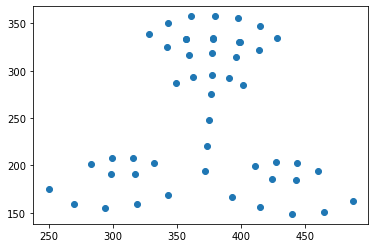

In [16]:
plt.scatter(TabSequences[0][:,0,0],TabSequences[0][:,0,1])
plt.show()

In [17]:
np.mean(TabSequences[0][:,0,:],axis=0)
frame = TabSequences[0][:,0,:]
normeDeFrobenius = np.linalg.norm(frame)
moyenne = np.mean(frame,axis=0)
print(normeDeFrobenius,moyenne)

3222.6112427728085 [374.06175727 252.97526959]


In [18]:
frame[:,0]-=moyenne[0]
frame[:,1]-=moyenne[1]
print(np.mean(frame,axis=0))
normeDeFrobenius = np.linalg.norm(frame)
frame/normeDeFrobenius

[-2.20413257e-14  2.84217094e-14]


array([[-0.19787591, -0.12483868],
       [-0.16649347, -0.14965833],
       [-0.12740261, -0.15613203],
       [-0.08757774, -0.14918187],
       [-0.0497776 , -0.13502917],
       [ 0.03001405, -0.13816051],
       [ 0.06567268, -0.15531984],
       [ 0.10507151, -0.1662878 ],
       [ 0.14547926, -0.16366206],
       [ 0.18104513, -0.14370659],
       [-0.00365165, -0.09457886],
       [-0.00034294, -0.0519796 ],
       [ 0.0023087 , -0.00791402],
       [ 0.00442389,  0.03595187],
       [-0.03907975,  0.05514308],
       [-0.01832768,  0.06466843],
       [ 0.00580994,  0.06769126],
       [ 0.02713225,  0.06200339],
       [ 0.04433894,  0.05142055],
       [-0.14497075, -0.08185829],
       [-0.12052058, -0.09944325],
       [-0.09035481, -0.09977426],
       [-0.06645833, -0.08025462],
       [-0.09273806, -0.07136426],
       [-0.11937734, -0.07122495],
       [ 0.059726  , -0.08555636],
       [ 0.08011388, -0.10755765],
       [ 0.11061469, -0.10992523],
       [ 0.13770424,

In [19]:
KendallProjection = frame/normeDeFrobenius

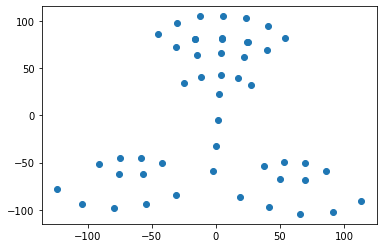

In [20]:
plt.scatter(frame[:,0],frame[:,1])
plt.show()

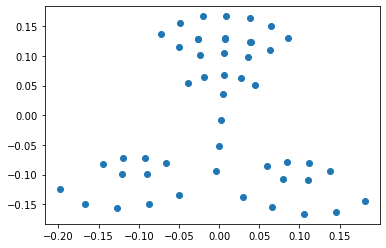

In [21]:
plt.scatter(KendallProjection[:,0],KendallProjection[:,1])
plt.show()

In [22]:
def projectFramePreshape(frame):
    #Tapez votre code ici
    moyenne = np.mean(frame,axis=0)
    frame[:,0] -=moyenne[0]
    frame[:,1] -=moyenne[1]
    normeDeFrobenius = np.linalg.norm(frame)
    return frame/normeDeFrobenius

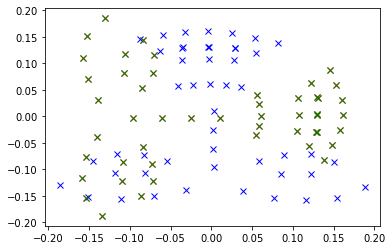

In [23]:
Sequence326 = TabSequences[326]
Frame = Sequence326[:,0,:]
FramePreshape = projectFramePreshape(Frame)

Frame1 = Sequence326[:,11,:]
Frame1Preshape = projectFramePreshape(Frame1)


a = np.array([[0, -1],[ 1, 0]], float)
Frame1Preshape90 = Frame1Preshape.dot(a)


# Calculate transform via procrustes...
FrameXX, Frame1PreshapeAligned, disparity = procrustes(Frame1Preshape90, Frame1Preshape)
#d,Frame1PreshapeAligned,Tform = procrustes(Frame1Preshape90,Frame1Preshape)



#visage1 = Frame326[:,0,:]
#plt.plot(FramePreshape[:,0],FramePreshape[:,1],'x')
#plt.savefig("FramePreshape.png")

plt.plot(Frame1Preshape90[:,0],Frame1Preshape90[:,1],'x',color='red')
plt.plot(Frame1Preshape[:,0],Frame1Preshape[:,1],'x',color='blue')
plt.plot(Frame1PreshapeAligned[:,0],Frame1PreshapeAligned[:,1],'x',color='green')

plt.savefig("FramePreshapeAligned.png")

plt.show()


In [24]:
def DProduitScalaireFrobinus(X,Y):
    """ Calcul de la distance entre la frame X et Y de la question 2.
    X et Y doivent être projeté sur l'espace de Kandall pour ne pas renvoyer une erreur
    
    Peut retourner une erreur si jamais le produit scalaire n'est pas compris entre -1 et 1.
    """
    YTranspose = Y.T
    # Calcul du produit scalaire 
    Scalaire = round(np.trace(np.dot(X,YTranspose)),6)
    #print("Scalaire : ",Scalaire) # Pour le debug
    return math.acos(Scalaire)
DProduitScalaireFrobinus(FramePreshape,Frame1Preshape)

0.03171883269679921

In [25]:
def AllFramesPreshape(Sequence):
    """Faire la projection de toutes les frames d'une séquence sur l'espace de Kendall.
    Param : 
    - Tab, matrice qui contient toutes les frames d'une séquence.
    
    Return : La matrice Tab avec toutes les frames centrées.
    """
    i=0
    SequencePreshape = Sequence.copy()
    while i<Sequence.shape[1]: 
        # Parcourir toutes les frames d'une séquence
        SequencePreshape[:,i,:] = projectFramePreshape(Sequence[:,i,:])
        i+=1
    return SequencePreshape

In [26]:
def AllSequencePreshape(Tab):
    """
    Appliquer la fonction AllFramesPreshape sur toutes les séquences contenue dans Tab
    """
    TabPreshape = Tab.copy()
    i=0
    while i<Tab.shape[0]:
        TabPreshape[i] = AllFramesPreshape(Tab[i])
        i+=1
    return TabPreshape

In [27]:
TabPreshape = AllSequencePreshape(TabSequences)
TabPreshape

array([array([[[-0.19787591, -0.12483868],
               [-0.20001613, -0.12346291],
               [-0.19713985, -0.12570064],
               ...,
               [-0.19811322, -0.12376153],
               [-0.19964991, -0.12285419],
               [-0.19769938, -0.12577854]],

              [[-0.16649347, -0.14965833],
               [-0.16717121, -0.14924517],
               [-0.1651561 , -0.1503245 ],
               ...,
               [-0.16458721, -0.14501474],
               [-0.16567893, -0.1440134 ],
               [-0.16400618, -0.14509411]],

              [[-0.12740261, -0.15613203],
               [-0.12732273, -0.15667188],
               [-0.12587609, -0.15590733],
               ...,
               [-0.12511494, -0.14941978],
               [-0.12537983, -0.14750377],
               [-0.12559391, -0.14824022]],

              ...,

              [[ 0.0398881 ,  0.12353163],
               [ 0.0390247 ,  0.12404685],
               [ 0.03974013,  0.12364644],
           

In [28]:
def DistanceEntreToutesLesFrames(sequence):
    """ 
    Calculer toutes les distances entres les frames d'une séquence.
    Inutile dans le TP mais peut-être utile plus tard si besoin
    """
    i=0
    j=0
    Distances = np.zeros((sequence.shape[1],sequence.shape[1]))
    while i<sequence.shape[1]:
        j=0
        while j<sequence.shape[1]:
            #print(i,j) # Pour le debug
            #print("Distance : ",DProduitScalaireFrobinus(sequence[:,i,:],sequence[:,j,:])) # Pour le debug
            Distances[i][j] = DProduitScalaireFrobinus(sequence[:,i,:],sequence[:,j,:])
            j+=1
        i+=1
    return Distances

In [29]:
def DistanceEntreDeuxSequences(sequence1,sequence2):
    taille = min(sequence1.shape[1],sequence2.shape[1])
    DistancesFrameParFrame = np.zeros(taille)
    i=0
    while i<taille:
        DistancesFrameParFrame[i] = DProduitScalaireFrobinus(sequence1[:,i,:],sequence2[:,i,:])
        i+=1
    return DistancesFrameParFrame.mean()

In [30]:
DistancesSequence0 = DistanceEntreToutesLesFrames(TabPreshape[0])

In [31]:
DistancesSequence0.shape

(11, 11)

In [32]:
DProduitScalaireFrobinus(TabPreshape[0][:,0,:],TabPreshape[0][:,0,:])

0.0

Pour la question 3 pour faire la distance il faut prendre la distance entre chaque frame (1 et 1 ou alors 1 avec toutes les autres (et prendre la distance minimale comme dtw) et trouver la distance moyenne entre toutes les frames.

In [33]:
def distanceEntreToutesLesSequence(Tab):
    i=0
    j=0
    distances = np.zeros((Tab.shape[0],Tab.shape[0]))
    while i<Tab.shape[0]:
        j=0
        distances[i][i]=50000 # Permet de ne pas prendre en compte cette valeur lors de l'entrainement du knn
        while j<i:
            distance = DistanceEntreDeuxSequences(Tab[i],Tab[j])
            distances[i][j]=distance
            distances[j][i]=distance
            j+=1
        i+=1 
    return distances

In [34]:
DistanceEntreDeuxSequences(TabPreshape[0],TabPreshape[20])

0.10154469695186488

In [35]:
DistanceEntreDeuxSequences(TabPreshape[20],TabPreshape[0])

0.10154469695186488

In [36]:
matriceDistancesSequence = distanceEntreToutesLesSequence(TabPreshape)
matriceDistancesSequence

array([[5.00000000e+04, 9.97740786e-02, 6.02984139e-02, ...,
        1.18677216e-01, 1.01979286e-01, 9.53982230e-02],
       [9.97740786e-02, 5.00000000e+04, 1.21657231e-01, ...,
        1.23318798e-01, 1.48047916e-01, 1.28095898e-01],
       [6.02984139e-02, 1.21657231e-01, 5.00000000e+04, ...,
        1.21568264e-01, 8.87281223e-02, 1.14376219e-01],
       ...,
       [1.18677216e-01, 1.23318798e-01, 1.21568264e-01, ...,
        5.00000000e+04, 1.61166964e-01, 1.48818322e-01],
       [1.01979286e-01, 1.48047916e-01, 8.87281223e-02, ...,
        1.61166964e-01, 5.00000000e+04, 6.56130702e-02],
       [9.53982230e-02, 1.28095898e-01, 1.14376219e-01, ...,
        1.48818322e-01, 6.56130702e-02, 5.00000000e+04]])

In [37]:
matriceDistancesSequence.shape

(327, 327)

In [38]:
print(matriceDistancesSequence[0,1],matriceDistancesSequence[1,0])
print(matriceDistancesSequence[0,0])

0.09977407855746367 0.09977407855746367
50000.0


In [39]:
from sklearn.neighbors import KNeighborsClassifier

In [40]:
knn = KNeighborsClassifier(algorithm="brute",n_neighbors=5)
knn.fit(matriceDistancesSequence,TabLabels)

KNeighborsClassifier(algorithm='brute')

In [41]:
knn.score(matriceDistancesSequence,TabLabels)

0.40672782874617736